# LinkNYC changes the 311 service requests

- Get LinkNYC kiosks information
    - Select 311 data time range
- Get 311 data
- Get ACS census data
    - Aggregate LinkNYC and 311 data into census block
- Overall changes analysis
    - WithKiosk and WithoutKiosk area
    - Hypothesis Testing
    - Conclusion
- Detail changes analysis (the total 311 complaint count)
    - 311 service request before and after LinkNYC built
    - Hypothesis Testing
    - Conclusion
- Detail changes analysis (the sidewalk noise 311 complaint count)
    - 311 service request about sidewalk noise before and after LinkNYC built
    - Hypothesis Testing
    - Conclusion

In [13]:
#import libraries
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gpd
import os
import datetime as dt
from matplotlib import gridspec
import fiona
from fiona.crs import from_epsg
import shapely
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#declare parameters
pd.set_option('display.max_columns', 500)
%pylab inline
zip_code_shpfile = os.environ['ZIP_CODE_SHPFILE']
linknyc_locations = os.environ['LINKNYC_LOCS']
policymap_broadband = os.environ['POLICYMAP_BROADBAND']
data_monthly_linknyc = os.environ['MONTHLY_LINKNYC']
socrata_key = os.environ['SOCRATA_KEY']
census_blocks = os.environ['CENSUS_BLOCKS']

Populating the interactive namespace from numpy and matplotlib


### Get LinkNYC kiosks information

Get the linkNYC location data with lon and lat.

In [15]:
linkLocation = pd.read_csv(linknyc_locations)

In [16]:
linkLocation.head()

,CB Link ID,Borough,Community Board,Council District,Latitude,Longitude,Project Status,Smallest PPT,Street Address,Postcode,Link Site ID,Link Smoke Tested and Activated (A),Link Installation (A),Neighborhood Tabulation Area (NTA),Building Identification Number (BIN),Borough-Block-Lot (BBL),Census Tract (CT),Cross Street 1,Cross Street 2,IxN Corner,GF Permit Application ID,Location
0,LINK-019315,Bronx,205,14,40.850173,-73.910282,Live,146097,1 EAST 177 STREET,10453,bx-05-146097,07/13/2018,06/20/2018,Mount Hope,2008247,2028530001,2023301,JEROME AVENUE,WALTON AVENUE,SE,82392.0,"(40.850173, -73.91028173)"
1,LINK-008842,Manhattan,105,4,40.747114,-73.985245,Live,121611,1 EAST 32 STREET,10016,mn-05-121611,12/09/2016,10/01/2016,Midtown-Midtown South,1017006,1008620001,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74711441, -73.98524463)"
2,LINK-008843,Manhattan,105,4,40.747737,-73.984833,Live,121613,1 EAST 33 STREET,10016,mn-05-121613,03/23/2017,01/29/2017,Midtown-Midtown South,1017076,1008630006,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74773664, -73.98483344)"
3,LINK-000186,Manhattan,105,2,40.734148,-73.988740,Live,134620,1 IRVING PLACE,10003,mn-05-134620,07/19/2017,06/11/2017,Gramercy,1083247,1008707501,1005000,EAST 14 STREET,EAST 15 STREET,NW,NaN,"(40.73414765, -73.98873983)"
4,LINK-010750,Manhattan,102,3,40.730258,-74.006629,Live,123600,1 ST. LUKE'S PLACE,10014,mn-02-123600,01/26/2017,11/13/2016,West Village,1009773,1005830001,1006700,HUDSON STREET,7 AVENUE,NE,NaN,"(40.73025769, -74.00662855)"


In [17]:
linkLocation.shape

(1868, 22)

Select 311 data time range

In [18]:
def minmax(val_list):
    min_val = min(val_list)
    max_val = max(val_list)

    return (min_val, max_val)

In [19]:
linkLocation['active_date'] = pd.to_datetime(linkLocation['Link Smoke Tested and Activated (A)'])

In [20]:
minmax(linkLocation.active_date)

(Timestamp('2016-01-19 00:00:00'), Timestamp('2019-03-28 00:00:00'))

To wipe off the impact of season, we decide to use 2015.04 and 2015.05 311 data as the data before kiosk built, and use 2019.04 and 2019.05 311 data as the data after kiosk built.

## Get 311 data

In [21]:
def get311data(key, start_time, end_time):
    client = Socrata("data.cityofnewyork.us", key)
    results = client.get("fhrw-4uyv", where = "created_date BETWEEN " + start_time + " AND " +  end_time, limit = 1000000000)
    
    return(pd.DataFrame.from_records(results))

In [ ]:
before = get311data(socrata_key,  "'2015-04-01T00:00:00'", "'2015-05-31T00:00:00'")

In [ ]:
after = get311data(socrata_key,  "'2019-04-01T00:00:00'", "'2019-05-31T00:00:00'")

In [ ]:
before = before[-before['location'].isna()].reset_index(drop = True)

In [22]:
before = pd.read_csv("before.csv")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
before.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,HPD,Department of Housing Preservation and Develop...,3.060090e+09,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2015-05-19T00:00:00.000,10 BROOKLYN,UNSANITARY CONDITION,2015-04-01T00:00:00.000,NaN,NaN,GARBAGE/RECYCLING STORAGE,NaN,NaN,552 82 STREET,11209.0,NaN,NaN,NaN,40.623571,"{'type': 'Point', 'coordinates': [-74.02352676...",RESIDENTIAL BUILDING,-74.023527,ONLINE,BROOKLYN,Unspecified,2015-05-19T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,82 STREET,NaN,NaN,30298583,NaN,977719,166461
1,ADDRESS,HPD,Department of Housing Preservation and Develop...,2.027240e+09,BRONX,NaN,NaN,NaN,BRONX,2015-04-03T00:00:00.000,02 BRONX,HEAT/HOT WATER,2015-04-01T00:00:00.000,NaN,NaN,APARTMENT ONLY,NaN,NaN,975 SIMPSON STREET,10459.0,NaN,NaN,NaN,40.821519,"{'type': 'Point', 'coordinates': [-73.89286979...",RESIDENTIAL BUILDING,-73.892870,PHONE,BRONX,Unspecified,2015-04-03T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,SIMPSON STREET,NaN,NaN,30299044,NaN,1013901,238597
2,ADDRESS,HPD,Department of Housing Preservation and Develop...,4.050438e+09,QUEENS,NaN,NaN,NaN,Flushing,2015-04-03T00:00:00.000,07 QUEENS,HEAT/HOT WATER,2015-04-01T00:00:00.000,NaN,NaN,ENTIRE BUILDING,NaN,NaN,136-05 SANFORD AVENUE,11355.0,NaN,NaN,NaN,40.756751,"{'type': 'Point', 'coordinates': [-73.82854025...",RESIDENTIAL BUILDING,-73.828540,ONLINE,QUEENS,Unspecified,2015-04-03T00:00:00.000,The complaint you filed is a duplicate of a co...,NaN,Closed,SANFORD AVENUE,NaN,NaN,30299153,NaN,1031752,215028
3,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1.004120e+09,MANHATTAN,NaN,NaN,NaN,NEW YORK,2015-04-01T00:00:00.000,03 MANHATTAN,Rodent,2015-04-01T00:00:00.000,STANTON STREET,EAST HOUSTON STREET,Rat Sighting,2015-05-01T01:21:51.000,NaN,192 ORCHARD STREET,10002.0,NaN,NaN,NaN,40.722179,"{'type': 'Point', 'coordinates': [-73.98813082...",Other (Explain Below),-73.988131,PHONE,MANHATTAN,Unspecified,2015-04-01T01:28:07.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,ORCHARD STREET,NaN,NaN,30299598,NaN,987540,202386
4,ADDRESS,HPD,Department of Housing Preservation and Develop...,1.021250e+09,MANHATTAN,NaN,NaN,NaN,NEW YORK,2015-04-12T00:00:00.000,12 MANHATTAN,UNSANITARY CONDITION,2015-04-01T00:00:00.000,NaN,NaN,PESTS,NaN,NaN,515 WEST 168 STREET,10032.0,NaN,NaN,NaN,40.840145,"{'type': 'Point', 'coordinates': [-73.93754560...",RESIDENTIAL BUILDING,-73.937546,PHONE,MANHATTAN,Unspecified,2015-04-12T00:00:00.000,The Department of Housing Preservation and Dev...,NaN,Closed,WEST 168 STREET,NaN,NaN,30299711,NaN,1001531,245371


In [24]:
before.shape

(331963, 41)

In [25]:
sidewalkBefore = before[before['complaint_type'] == 'Noise - Street/Sidewalk'].reset_index(drop = True)

In [ ]:
after = after[-after['location'].isna()].reset_index(drop = True)

In [27]:
after = pd.read_csv("after.csv")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
after.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3.037200e+09,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2019-04-01T00:00:00.000,05 BROOKLYN,Rodent,2019-04-01T00:00:00.000,GLENMORE AVENUE,PITKIN AVENUE,Rat Sighting,2019-05-01T02:13:32.000,NaN,177 SHEFFIELD AVENUE,11207.0,NaN,NaN,NaN,40.672827,"{'type': 'Point', 'coordinates': [-73.89710656...",3+ Family Mixed Use Building,-73.897107,ONLINE,BROOKLYN,Unspecified,2019-04-01T02:16:23.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,SHEFFIELD AVENUE,NaN,NaN,42098134,NaN,1012792,184422
1,LATLONG,DOHMH,Department of Health and Mental Hygiene,NaN,MANHATTAN,NaN,NaN,NaN,NEW YORK,2019-04-01T00:00:00.000,Unspecified MANHATTAN,Rodent,2019-04-01T00:00:00.000,NaN,NaN,Rat Sighting,2019-05-01T01:54:21.000,NaN,190 HESTER STREET,10013.0,NaN,NaN,NaN,40.718131,"{'type': 'Point', 'coordinates': [-73.99849930...",Commercial Building,-73.998499,MOBILE,MANHATTAN,Unspecified,2019-04-01T01:57:06.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,HESTER STREET,NaN,NaN,42098838,NaN,984666,200911
2,ADDRESS,DOHMH,Department of Health and Mental Hygiene,2.027980e+09,BRONX,NaN,NaN,NaN,BRONX,2019-04-01T00:00:00.000,05 BRONX,Rodent,2019-04-01T00:00:00.000,CROSS BRONX EXPRESSWAY,EAST 175 STREET,Condition Attracting Rodents,2019-05-01T01:35:01.000,NaN,1748 MONROE AVENUE,10457.0,NaN,NaN,NaN,40.845902,"{'type': 'Point', 'coordinates': [-73.90654342...",3+ Family Apt. Building,-73.906543,PHONE,BRONX,Unspecified,2019-04-01T01:47:59.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,MONROE AVENUE,NaN,NaN,42102064,NaN,1010107,247476
3,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3.009630e+09,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2019-04-01T00:00:01.000,06 BROOKLYN,Food Poisoning,2019-04-01T00:00:00.000,CARROLL STREET,GARFIELD PLACE,1 or 2,2019-04-15T10:52:19.000,NaN,152 7 AVENUE,11215.0,NaN,NaN,NaN,40.672508,"{'type': 'Point', 'coordinates': [-73.97691380...",Restaurant/Bar/Deli/Bakery,-73.976914,ONLINE,BROOKLYN,Unspecified,2019-04-11T11:45:27.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,7 AVENUE,NaN,NaN,42104690,NaN,990654,184290
4,ADDRESS,DOHMH,Department of Health and Mental Hygiene,NaN,QUEENS,NaN,NaN,NaN,SOUTH RICHMOND HILL,2019-04-11T00:00:01.000,10 QUEENS,Food Poisoning,2019-04-01T00:00:00.000,LIBERTY AVENUE,120 STREET,1 or 2,2019-04-15T08:43:18.000,NaN,120 Liberty Avenue,11419.0,120 STREET,LIBERTY AVENUE,NaN,40.686573,"{'type': 'Point', 'coordinates': [-73.82329768...",Restaurant/Bar/Deli/Bakery,-73.823298,PHONE,QUEENS,Unspecified,2019-04-11T11:20:56.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,Liberty Avenue,NaN,NaN,42104689,NaN,1033256,189463


In [29]:
after.shape

(433552, 41)

In [30]:
sidewalkAfter = after[after['complaint_type'] == 'Noise - Street/Sidewalk'].reset_index(drop = True)

In [31]:
before['latitude'] = before['latitude'].apply(lambda x: float(x)).tolist()
before['longitude'] = before['longitude'].apply(lambda x: float(x)).tolist()
after['latitude'] = after['latitude'].apply(lambda x: float(x)).tolist()
after['longitude'] = after['longitude'].apply(lambda x: float(x)).tolist()

In [32]:
sidewalkBefore['latitude'] = sidewalkBefore['latitude'].apply(lambda x: float(x)).tolist()
sidewalkBefore['longitude'] = sidewalkBefore['longitude'].apply(lambda x: float(x)).tolist()
sidewalkAfter['latitude'] = sidewalkAfter['latitude'].apply(lambda x: float(x)).tolist()
sidewalkAfter['longitude'] = sidewalkAfter['longitude'].apply(lambda x: float(x)).tolist()

In [33]:
(after.shape[0]+0.0)/before.shape[0]

1.306025069058901

In [74]:
totalRate = round((after.shape[0]+0.0)/before.shape[0], 2)

The overall 311 complaint counts of NYC is increased about 31%.

In [34]:
(sidewalkAfter.shape[0]+0.0)/sidewalkBefore.shape[0]

1.6293672824734373

In [76]:
sidewalkRate = round((sidewalkAfter.shape[0]+0.0)/sidewalkBefore.shape[0], 2)

The 311 complaint about sidewalk noise of NYC is increased about 63%.

### Get ACS census data

In [37]:
censusBlock = gpd.GeoDataFrame.from_file(census_blocks)

In [38]:
censusBlock.head()

,bctcb2010,boro_code,boro_name,cb2010,ct2010,shape_area,shape_leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374567...
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438017 40.61085506705416...
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452712...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123925...
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...


In [41]:
# sum(censusBlock.isna())

In [42]:
censusBlock.shape

(38796, 8)

Aggregate LinkNYC and 311 data into census block.

In [45]:
# import pyproj
# pyproj.Proj("+init=epsg:4326")

linkLocation['lonlat'] = list(zip(linkLocation.Longitude,linkLocation.Latitude))
linkLocation['geometry'] = linkLocation[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

linkLocation = gpd.GeoDataFrame(linkLocation)
linkLocation.crs = from_epsg(4326)

linkLocation_ft = linkLocation.to_crs(epsg=2263)
censusBlock_ft = censusBlock.to_crs(epsg=2263)

In [46]:
kioskCountBlock = gpd.sjoin(censusBlock_ft, linkLocation_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'linknycCount'})
kioskCountBlock.reset_index(inplace = True)

In [47]:
kioskCountBlock = censusBlock_ft.merge(kioskCountBlock, how = 'outer')[['bctcb2010', 'linknycCount']].fillna(0)

In [48]:
kioskCountBlock['linknycCount'] = kioskCountBlock['linknycCount'].apply(lambda x: int(x)).tolist()

In [49]:
before['lonlat'] = list(zip(before.longitude,before.latitude))
before['geometry'] = before[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

before = gpd.GeoDataFrame(before)
before.crs = from_epsg(4326)

before_ft = before.to_crs(epsg=2263)
#censusBlock_ft = censusBlock.to_crs(epsg=2263)

In [50]:
sidewalkBefore['lonlat'] = list(zip(sidewalkBefore.longitude,sidewalkBefore.latitude))
sidewalkBefore['geometry'] = sidewalkBefore[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

sidewalkBefore = gpd.GeoDataFrame(sidewalkBefore)
sidewalkBefore.crs = from_epsg(4326)

sidewalkBefore_ft = sidewalkBefore.to_crs(epsg=2263)

In [51]:
after['lonlat'] = list(zip(after.longitude,after.latitude))
after['geometry'] = after[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

after = gpd.GeoDataFrame(after)
after.crs = from_epsg(4326)

after_ft = after.to_crs(epsg=2263)

In [52]:
sidewalkAfter['lonlat'] = list(zip(sidewalkAfter.longitude,sidewalkAfter.latitude))
sidewalkAfter['geometry'] = sidewalkAfter[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

sidewalkAfter = gpd.GeoDataFrame(sidewalkAfter)
sidewalkAfter.crs = from_epsg(4326)

sidewalkAfter_ft = sidewalkAfter.to_crs(epsg=2263)

In [53]:
before311CountBlock = gpd.sjoin(censusBlock_ft, before_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'beforeCount'})
before311CountBlock.reset_index(inplace = True)

In [54]:
sidewalkBefore311CountBlock = gpd.sjoin(censusBlock_ft, sidewalkBefore_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'beforeCount'})
sidewalkBefore311CountBlock.reset_index(inplace = True)

In [55]:
after311CountBlock = gpd.sjoin(censusBlock_ft, after_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'afterCount'})
after311CountBlock.reset_index(inplace = True)

In [56]:
sidewalkAfter311CountBlock = gpd.sjoin(censusBlock_ft, sidewalkAfter_ft).groupby('bctcb2010').size().to_frame().rename(columns = {0: 'afterCount'})
sidewalkAfter311CountBlock.reset_index(inplace = True)

In [57]:
before311CountBlock = censusBlock_ft.merge(before311CountBlock, how = 'outer')[['bctcb2010', 'beforeCount']].fillna(0)
after311CountBlock = censusBlock_ft.merge(after311CountBlock, how = 'outer')[['bctcb2010', 'afterCount']].fillna(0)

In [58]:
sidewalkBefore311CountBlock = censusBlock_ft.merge(sidewalkBefore311CountBlock, how = 'outer')[['bctcb2010', 'beforeCount']].fillna(0)
sidewalkAfter311CountBlock = censusBlock_ft.merge(sidewalkAfter311CountBlock, how = 'outer')[['bctcb2010', 'afterCount']].fillna(0)

In [59]:
before311CountBlock['beforeCount'] = before311CountBlock['beforeCount'].apply(lambda x: int(x)).tolist()
after311CountBlock['afterCount'] = after311CountBlock['afterCount'].apply(lambda x: int(x)).tolist()

In [60]:
sidewalkBefore311CountBlock['beforeCount'] = sidewalkBefore311CountBlock['beforeCount'].apply(lambda x: int(x)).tolist()
sidewalkAfter311CountBlock['afterCount'] = sidewalkAfter311CountBlock['afterCount'].apply(lambda x: int(x)).tolist()

In [61]:
before311CountBlock.head()

,bctcb2010,beforeCount
0,50009001000,8
1,50020011000,2
2,50027001000,48
3,50040001000,2
4,50064001000,2


In [62]:
after311CountBlock.head()

,bctcb2010,afterCount
0,50009001000,13
1,50020011000,0
2,50027001000,42
3,50040001000,3
4,50064001000,3


In [63]:
sidewalkBefore311CountBlock.head()

,bctcb2010,beforeCount
0,50009001000,0
1,50020011000,0
2,50027001000,1
3,50040001000,0
4,50064001000,0


In [64]:
sidewalkAfter311CountBlock.head()

,bctcb2010,afterCount
0,50009001000,0
1,50020011000,0
2,50027001000,7
3,50040001000,1
4,50064001000,0


## Overall changes analysis
- WithKiosk and WithoutKiosk area
- Hypothesis Testing
- Conclusion

Use after data for this analysis.

In [65]:
kioskCountBlock['Label'] = 'with'
kioskCountBlock['Label'][kioskCountBlock['linknycCount'] == 0] = 'without'

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [66]:
kioskCountBlock.head()

,bctcb2010,linknycCount,Label
0,50009001000,0,without
1,50020011000,0,without
2,50027001000,0,without
3,50040001000,0,without
4,50064001000,0,without


In [67]:
linkWithComplaint = kioskCountBlock.merge(after311CountBlock).rename(columns = {'afterCount': '311Count'})

In [68]:
linkWithComplaint.head()

,bctcb2010,linknycCount,Label,311Count
0,50009001000,0,without,13
1,50020011000,0,without,0
2,50027001000,0,without,42
3,50040001000,0,without,3
4,50064001000,0,without,3


In [69]:
linkWithComplaintShape = censusBlock.merge(linkWithComplaint)

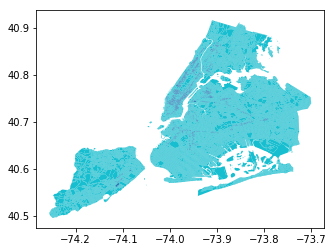

In [70]:
linkWithComplaintShape.plot('Label')

**Null Hypothesis: There is no different of 311 total complaints counts between with kiosk and without kiosk area.**

$$ H_0: \mu_{withKiosk} = \mu_{withoutKiosk} $$

$$ H_1: \mu_{withKiosk} \neq \mu_{withoutKiosk} $$

$$ p = 0.05 $$

In [71]:
def z_test(s1, s2):
    u1 = np.mean(s1)
    u2 = np.mean(s2)
    v1 = np.var(s1)
    v2 = np.var(s2)
    n1 = len(s1)
    n2 = len(s2)
    
    z_score = (u1 - u2)/np.sqrt(v1/n1 + v2/n2)
    
    return z_score

In [72]:
withKiosk = linkWithComplaint['311Count'][linkWithComplaint['Label'] == 'with']
withoutKiosk = linkWithComplaint['311Count'][linkWithComplaint['Label'] == 'without']

In [73]:
z_test(withKiosk, withoutKiosk)

24.442638888675329

As z score is much higher than 1.96, we could reject $H_0$ and say that there is significant different of 311 total complaints counts between with kiosk and without kiosk area.

## Detail changes analysis (the total 311 complaint count)
- 311 service request before and after LinkNYC built
- Hypothesis Testing
- Conclusion

In [77]:
before311LinkCount = kioskCountBlock[kioskCountBlock['Label'] == 'with'].merge(before311CountBlock) \
.rename(columns = {'beforeCount': '311Count'}).reset_index(drop = True)

In [78]:
before311LinkCount.head()

,bctcb2010,linknycCount,Label,311Count
0,50112021004,2,with,0
1,50122001005,1,with,7
2,50114021008,1,with,6
3,50114021011,1,with,4
4,50112021012,1,with,2


In [79]:
after311LinkCount = kioskCountBlock[kioskCountBlock['Label'] == 'with'].merge(after311CountBlock) \
.rename(columns = {'afterCount': '311Count'}).reset_index(drop = True)

In [80]:
after311LinkCount.head()

,bctcb2010,linknycCount,Label,311Count
0,50112021004,2,with,1
1,50122001005,1,with,28
2,50114021008,1,with,4
3,50114021011,1,with,3
4,50112021012,1,with,9


In [81]:
before = before311LinkCount['311Count'] * totalRate # take the increase rate into account
after = after311LinkCount['311Count'] 

**Null Hypothesis: There is no different of 311 total complaints counts before and after LinkNYC kiosk built.**

$$ H_0: \mu_{before} = \mu_{after} $$

$$ H_1: \mu_{before} \neq \mu_{after} $$

$$ p = 0.05 $$

In [82]:
z_test(before, after)

2.5824652273226452

In [85]:
sum(before), sum(after)

(46253.480000000003, 41617)

As z score is higher than 1.96, we could reject $H_0$ and say that there is significant different of 311 total complaints counts before and after LinkNYC kiosk built.

## Detail changes analysis (the sidewalk noise 311 complaint count)
- 311 service request about sidewalk noise before and after LinkNYC built
- Hypothesis Testing
- Conclusion

**Null Hypothesis: There is no different of 311 sidewalk complaints counts before and after LinkNYC kiosk built.**

$$ H_0: \mu_{sidewalk\_before} = \mu_{sidewalk\_after} $$

$$ H_1: \mu_{sidewalk\_before} \neq \mu_{sidewalk\_after} $$

$$ p = 0.05 $$

In [86]:
sidewalkBefore311LinkCount = kioskCountBlock[kioskCountBlock['Label'] == 'with'].merge(sidewalkBefore311CountBlock) \
.rename(columns = {'beforeCount': '311Count'}).reset_index(drop = True)

In [87]:
sidewalkAfter311LinkCount = kioskCountBlock[kioskCountBlock['Label'] == 'with'].merge(sidewalkAfter311CountBlock) \
.rename(columns = {'afterCount': '311Count'}).reset_index(drop = True)

In [92]:
sidewalkBeforeCount = sidewalkBefore311LinkCount['311Count']
sidewalkAfterCount = sidewalkAfter311LinkCount['311Count']

In [93]:
z_test(sidewalkBeforeCount, sidewalkAfterCount)

-3.5345596707623161

In [94]:
sum(sidewalkBeforeCount), sum(sidewalkAfterCount)

(1823, 2834)

As z score is higher than 1.96, we could reject $H_0$ and say that there is significant different of 311 sidewalk complaints counts before and after LinkNYC kiosk built.